In [1]:
# 1. torchaudio 설치
!pip install torchaudio

# 2. Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
from pathlib import Path
import torchaudio
import torch

# 1. Drive 내 데이터셋 경로 설정
# Drive에 'AI_lab/My_Audio_Data' 폴더를 만들었으므로 경로를 설정
DATASET_FOLDER_NAME = 'AI_lab/My_Audio_Data'
DATASET_ROOT = Path('/content/drive/MyDrive') / DATASET_FOLDER_NAME

# 2. 데이터셋 폴더가 존재하는지 확인
if not DATASET_ROOT.is_dir():
    print(f"오류: 지정된 데이터셋 경로가 존재하지 않습니다. 경로를 확인해주세요: {DATASET_ROOT}")
else:
    # 3. 모든 오디오 파일 (.m4a) 목록 가져오기
    file_list = sorted(glob.glob(str(DATASET_ROOT / '**/*.m4a'), recursive=True))

    print(f"총 오디오 파일 개수: {len(file_list)}")
    if len(file_list) > 0:
        test_path = file_list[0]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"첫 번째 파일: {Path(test_path).name}")

        # 4. torchaudio를 사용하여 첫 번째 오디오 파일 로드 및 확인
        try:
            # waveform과 sample_rate를 로드
            waveform, sample_rate = torchaudio.load(test_path)

            # Resampling 코드에서 사용할 전역 변수 설정
            globals()['waveform'] = waveform.to(device)
            globals()['sample_rate'] = sample_rate
            globals()['test_path'] = Path(test_path)

            print(f"--- 로드 성공 ---")
            print(f"파형 형태: {waveform.shape}, SR: {sample_rate} Hz")
            print(f"데이터가 Resampling 코드 실행 준비 완료됨.")

        except Exception as e:
            print(f"\n파일 로드 중 오류 발생: {e}")
            print("오류 발생 시, 오디오 파일 형식을 `.wav`로 변환하여 다시 시도해 보세요.")
    else:
        print("경고: 지정된 폴더에서 오디오 파일을 찾을 수 없습니다. 확장자를 확인해 주세요.")

총 오디오 파일 개수: 4
첫 번째 파일: 095522039.m4a


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

--- 로드 성공 ---
파형 형태: torch.Size([1, 177152]), SR: 44100 Hz
데이터가 Resampling 코드 실행 준비 완료됨.


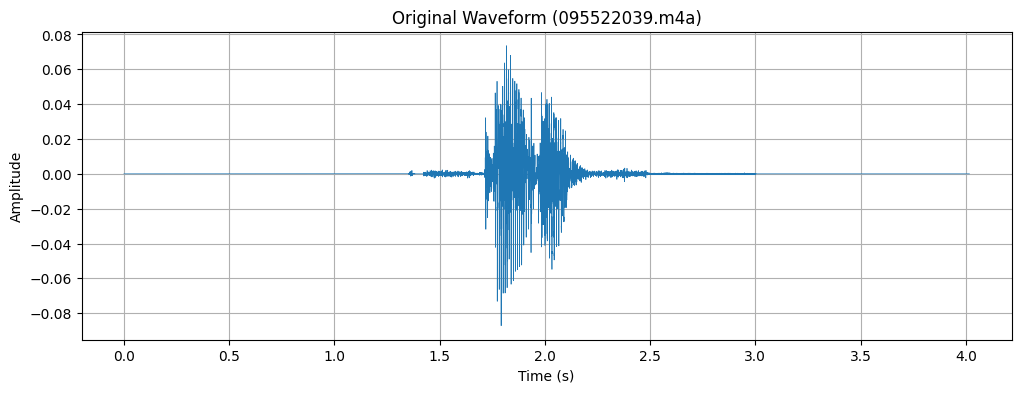

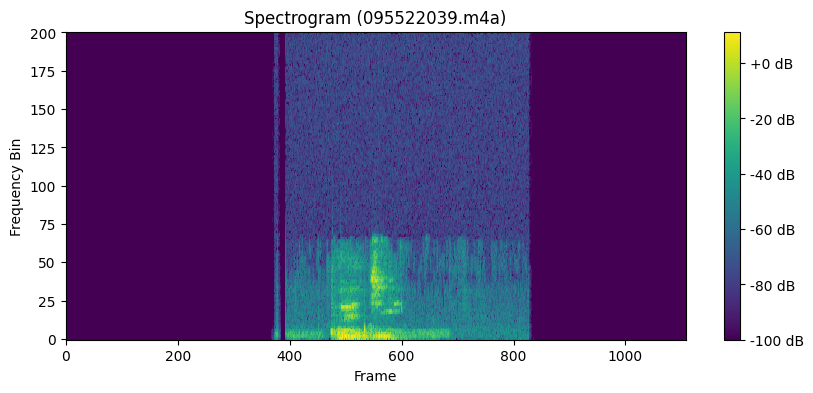

In [3]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torch

# ----------------- Waveform 시각화 -----------------
def plot_waveform(waveform, sample_rate, title="Waveform"):
    waveform = waveform.detach().cpu().numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    plt.figure(figsize=(12, 4))
    if num_channels == 1:
        plt.plot(time_axis, waveform[0], linewidth=0.5)
    else:
        # 스테레오일 경우
        plt.plot(time_axis, waveform.T)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# ----------------- Spectrogram 시각화 -----------------
def plot_spectrogram(spec, title="Spectrogram"):
    # 스펙트로그램은 일반적으로 로그 스케일로 시각화
    spec_db = T.AmplitudeToDB()(spec)

    plt.figure(figsize=(10, 4))
    plt.imshow(spec_db[0].cpu().numpy(), origin='lower', aspect='auto', interpolation='nearest')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.ylabel("Frequency Bin")
    plt.xlabel("Frame")
    plt.show()

# Waveform 시각화 실행
plot_waveform(waveform, sample_rate, title=f"Original Waveform ({test_path.name})")

# Spectrogram 계산 및 시각화 실행
n_fft = 400
win_length = None # Let torchaudio handle default win_length if None
hop_length = 160
# Create a window tensor and move it to the same device as the waveform
window = torch.hann_window(n_fft).to(waveform.device)

spectrogram_transform = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0, # Power-to-Magnitude-Squared
    window_fn=lambda x: window[:x] # Pass the window function
)
spectrogram = spectrogram_transform(waveform)
plot_spectrogram(spectrogram, title=f"Spectrogram ({test_path.name})")

Original: torch.Size([1, 177152]) sr: 44100
Down    : torch.Size([1, 64273]) sr: 16000
Up      : torch.Size([1, 177153]) sr: 44100


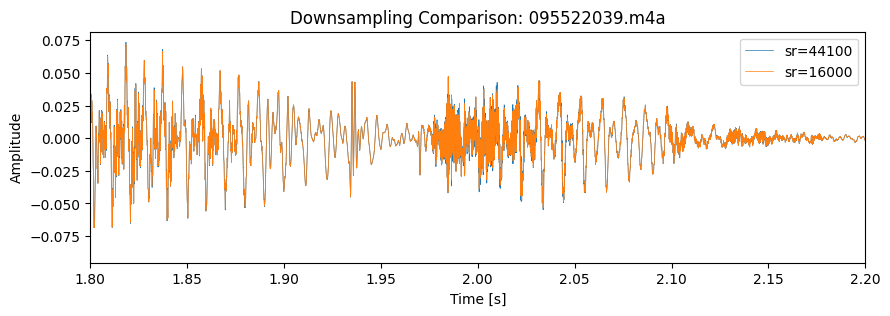

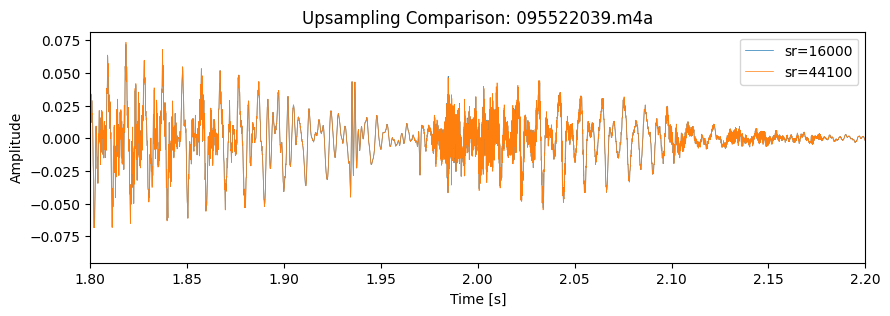

In [4]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torch

# --- Waveform 비교 그래프 함수 정의 ---
def plot_compare_waves(w1, sr1, w2, sr2, title, time_range=None):
    """Resampled Waveform을 확대하여 비교합니다."""

    # 텐서 데이터를 CPU로 이동하고 NumPy 배열로 변환
    x1 = w1[0].detach().cpu().numpy()
    x2 = w2[0].detach().cpu().numpy()
    t1 = [i/sr1 for i in range(len(x1))]
    t2 = [i/sr2 for i in range(len(x2))]

    plt.figure(figsize=(10, 3))
    plt.plot(t1, x1, label=f"sr={sr1}", linewidth=0.5)
    plt.plot(t2, x2, label=f"sr={sr2}", linewidth=0.5)
    plt.title(title); plt.xlabel("Time [s]"); plt.ylabel("Amplitude"); plt.legend()

    if time_range:
        plt.xlim(*time_range)  # 특정 시간 구간으로 줌인

    plt.show()


# --- Resampling 변환 정의 및 실행 ---
orig_sr = sample_rate         # 원본 샘플링 레이트
down_sr = 16000      # 목표 다운샘플링 레이트 (예: 16kHz)
up_sr   = orig_sr    # 목표 업샘플링 레이트 (원본과 동일)

# Resample 변환기 생성 (GPU 사용)
downsampler = T.Resample(orig_freq=orig_sr, new_freq=down_sr).to(device)
upsampler   = T.Resample(orig_freq=down_sr, new_freq=up_sr).to(device)

# Resampling 수행
wave_down = downsampler(waveform)
wave_up   = upsampler(wave_down)

print("Original:", waveform.shape, "sr:", orig_sr)
print("Down    :", wave_down.shape, "sr:", down_sr)
print("Up      :", wave_up.shape, "sr:", up_sr)


# --- 비교 그래프 출력 ---
# 줌인 구간 설정 (예시 이미지와 동일하게 1.8초부터 2.2초까지)
TIME_RANGE = (1.8, 2.2)

# 1. Downsampling 결과 시각화 (원본 vs 다운샘플링)
plot_compare_waves(waveform, orig_sr, wave_down, down_sr,
                   f"Downsampling Comparison: {test_path.name}",
                   time_range=TIME_RANGE)

# 2. Upsampling 결과 시각화 (다운샘플링 vs 업샘플링)
plot_compare_waves(wave_down, down_sr, wave_up, up_sr,
                   f"Upsampling Comparison: {test_path.name}",
                   time_range=TIME_RANGE)